# IMPORTS

In [1]:
import numpy as np
from datetime import datetime
from pathlib import Path
from IPython.display import clear_output
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import load_model
from visualkeras import layered_view
from keras.datasets import mnist, fashion_mnist, cifar10
from keras.utils.vis_utils import plot_model
from sklearn.utils import shuffle

from gand.config import MLConfig
from gand.data import data
from gand.models import models, architecture
from gand.visualisation import visualise
from gand.preprocessing import utils

import pandas as pd
from tabulate import tabulate
from tqdm.keras import TqdmCallback

from sklearn.metrics import classification_report


In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
dataset = cifar10
EPOCHS = 100
BATCH_SIZE = MLConfig.BATCH_SIZE

loss = "categorical_crossentropy"
opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.001, momentum=0.9)
metrics = ["accuracy"]

g_model_mnist = load_model(Path.cwd() / 'reports/models/cgan/mnist/gen_model_e-200.h5')
g_model_fashion_mnist = load_model(Path.cwd() / 'reports/models/cgan/fashion_mnist/gen_model_e-536.h5')
g_model_cifar10 = load_model(Path.cwd() / 'reports/models/cgan/cifar10/gen_model_e-553.h5')
g_model = g_model_cifar10

In [7]:
architecture.deep_model().summary()

Model: "deep_model_stable"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)  

# NORMAL DATA

In [57]:
((X_train_real, y_train_real), (X_test_real, y_test_real)), dataset_name = data.load_dataset(dataset, return_name=True)
print(X_train_real.shape, y_train_real.shape, X_test_real.shape, y_test_real.shape)

X_train_real, y_train_real = utils.preprocess_data(X_train_real, y_train_real, exp_dims=False)
X_test_real, y_test_real = utils.preprocess_data(X_test_real, y_test_real, exp_dims=False)

X_train_real.shape, y_train_real.shape, X_test_real.shape, y_test_real.shape, dataset_name

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10), 'cifar10')

In [58]:
X_train, y_train = shuffle(X_train_real, y_train_real)
X_test, y_test = shuffle(X_test_real, y_test_real)

In [60]:
train_type = 0

model = architecture.deep_model(img_shape=(32, 32, 3))
model.compile(loss=loss, optimizer=opt, metrics=metrics)

history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test),
                    batch_size=BATCH_SIZE, verbose=0, callbacks=[TqdmCallback(verbose=1)], 
                    shuffle=True)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [61]:
eval_data = (X_train, y_train), (X_test, y_test)
models.save_metrics(dataset_name=dataset_name, train_type=train_type,
                   epochs=EPOCHS, model=model, eval_data=eval_data, 
                   history=history)

In [62]:
history_path = Path.cwd() / f'reports/history/{dataset_name}/{MLConfig.TYPE_NAMES[0]}/E_{EPOCHS:03d}/'
history_path.mkdir(parents=True, exist_ok=True)
pd.DataFrame.from_dict(history.history).to_csv(history_path / f'{model.name}.csv',index=False)

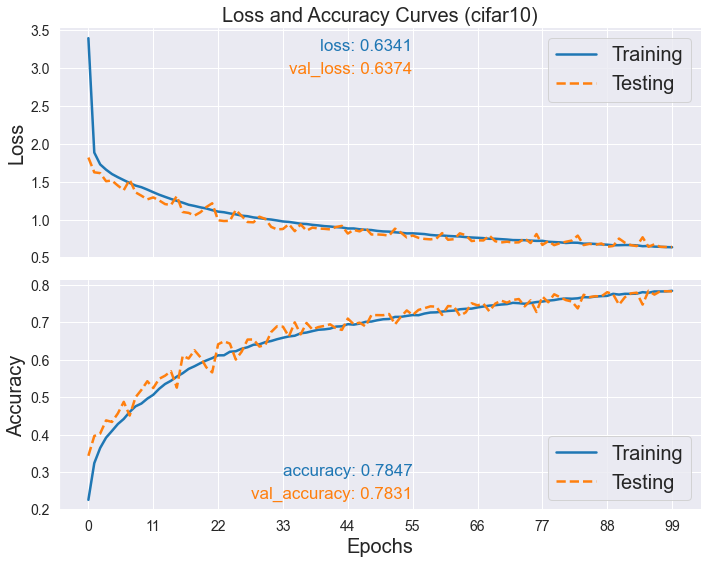

In [63]:
visualise.metric_plot(show_fig=True, history=history, dataset_name=dataset_name, 
                      savefig=False, epochs=EPOCHS)

# GAN Data

In [78]:
n = 3000 #PER CLASS
X_train_gan, y_train_gan = data.generate_fake_data(n=n, g_model=g_model, seed=10)
X_train_gan, y_train_gan = utils.preprocess_data(X_train_gan, y_train_gan, val_255=False, exp_dims=False)

# n = 500 #PER CLASS
# X_test_gan, y_test_gan = data.generate_fake_data(n=n, g_model=g_model, seed=20)
# X_test_gan, y_test_gan = utils.preprocess_data(X_test_gan, y_test_gan, val_255=False, exp_dims=False)

# X_train_gan.shape, y_train_gan.shape, X_test_gan.shape, y_test_gan.shape
X_train_gan.shape, y_train_gan.shape

938/938 [==============================] - 18s 19ms/step


((30000, 32, 32, 3), (30000, 10))

In [79]:
# REMOVING HALF OF THE DATA
((X_train_real, y_train_real), (X_test_real, y_test_real)), dataset_name = data.load_dataset(dataset, return_name=True)
print(X_train_real.shape, y_train_real.shape, X_test_real.shape, y_test_real.shape)

remove_train = X_train_real.shape[0] // (2 * 10)

X_train_removed, y_train_removed = [], []

for i in range(10):
    class_idx = np.where(X_train_real == i)[0]
    selected_idx = np.random.choice(class_idx, remove_train)
    X_train_removed.append(X_train_real[selected_idx])
    y_train_removed.append(y_train_real[selected_idx])

X_train_real, y_train_real = np.concatenate(X_train_removed, axis=0), np.concatenate(y_train_removed, axis=0)

X_train_real, y_train_real = utils.preprocess_data(X_train_real, y_train_real, exp_dims=False)
X_test_real, y_test_real = utils.preprocess_data(X_test_real, y_test_real, exp_dims=False)

X_train_real.shape, y_train_real.shape, dataset_name

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


((25000, 32, 32, 3), (25000, 10), 'cifar10')

In [80]:
X_train = np.concatenate((X_train_real, X_train_gan), axis=0)
y_train = np.concatenate((y_train_real, y_train_gan), axis=0)

# FOR TESTING HOW THE MODEL PERFORMS ON AUGMENTED DATA
# X_test_augmented = np.concatenate((X_test_real, X_test_gan), axis=0)
# y_test_augmented = np.concatenate((y_test_real, y_test_gan), axis=0)

In [81]:
# SHUFFLE ALL THE DATA
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test_real, y_test_real)
# X_test_augmented, y_test_augmented = shuffle(X_test_augmented, y_test_augmented)

In [82]:
# X_train.shape, y_train.shape, X_test_augmented.shape, y_test_augmented.shape
X_train.shape, y_train.shape

((55000, 32, 32, 3), (55000, 10))

In [84]:
train_type = 2

model = architecture.deep_model(img_shape=(32, 32, 3))
model.compile(loss=loss, optimizer=opt, metrics=metrics)

history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test),
                    batch_size=BATCH_SIZE, verbose=0, callbacks=[TqdmCallback(verbose=1)], 
                    shuffle=True)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [85]:
eval_data = (X_train, y_train), (X_test, y_test)
models.save_metrics(dataset_name=dataset_name, train_type=train_type,
                   epochs=EPOCHS, model=model, eval_data=eval_data, 
                   history=history)

In [86]:
history_path = Path.cwd() / f'reports/history/{dataset_name}/{MLConfig.TYPE_NAMES[2]}/E_{EPOCHS:03d}/'
history_path.mkdir(parents=True, exist_ok=True)
pd.DataFrame.from_dict(history.history).to_csv(history_path / f'{model.name}.csv',index=False)

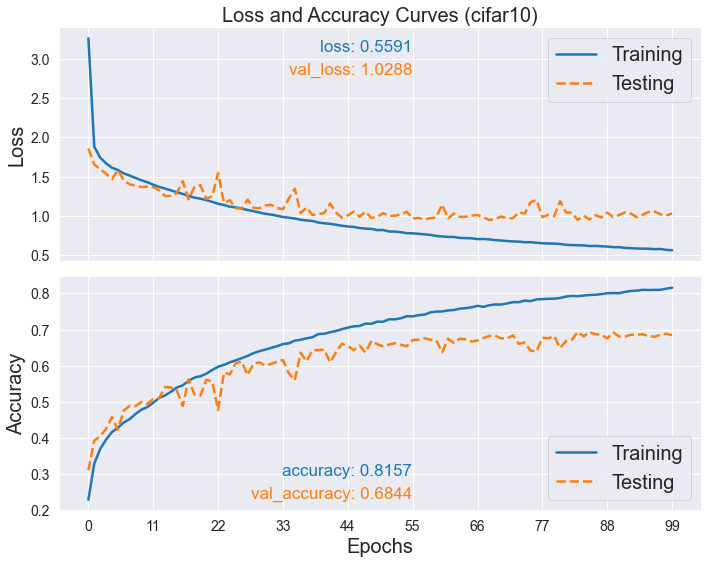

In [87]:
visualise.metric_plot(show_fig=True, history=history, dataset_name=dataset_name,
                      savefig=False, epochs=EPOCHS)

# IMBALANCED DATA

In [68]:
# REMOVING HALF OF THE DATA
((X_train_real, y_train_real), (X_test_real, y_test_real)), dataset_name = data.load_dataset(dataset, return_name=True)
print(X_train_real.shape, y_train_real.shape, X_test_real.shape, y_test_real.shape)

remove_train = X_train_real.shape[0] // (2 * 10) # 3000

X_train_removed, y_train_removed = [], []

for i in range(10):
    class_idx = np.where(X_train_real == i)[0]
    selected_idx = np.random.choice(class_idx, remove_train)
    X_train_removed.append(X_train_real[selected_idx])
    y_train_removed.append(y_train_real[selected_idx])

X_train_real, y_train_real = np.concatenate(X_train_removed, axis=0), np.concatenate(y_train_removed, axis=0)

X_train_real, y_train_real = utils.preprocess_data(X_train_real, y_train_real, exp_dims=False)
X_test_real, y_test_real = utils.preprocess_data(X_test_real, y_test_real, exp_dims=False)

X_train_real.shape, y_train_real.shape, dataset_name

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


((25000, 32, 32, 3), (25000, 10), 'cifar10')

In [69]:
X_train, y_train = shuffle(X_train_real, y_train_real)
X_test, y_test = shuffle(X_test_real, y_test_real)

In [70]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000, 32, 32, 3), (25000, 10), (10000, 32, 32, 3), (10000, 10))

In [72]:
train_type = 3

model = architecture.deep_model(img_shape=(32, 32, 3))
model.compile(loss=loss, optimizer=opt, metrics=metrics)

history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test),
                    batch_size=BATCH_SIZE, verbose=0, callbacks=[TqdmCallback(verbose=1)], 
                    shuffle=True)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [73]:
eval_data = (X_train, y_train), (X_test, y_test)
models.save_metrics(dataset_name=dataset_name, train_type=train_type,
                   epochs=EPOCHS, model=model, eval_data=eval_data, 
                   history=history)

In [74]:
history_path = Path.cwd() / f'reports/history/{dataset_name}/{MLConfig.TYPE_NAMES[3]}/E_{EPOCHS:03d}/'
history_path.mkdir(parents=True, exist_ok=True)
pd.DataFrame.from_dict(history.history).to_csv(history_path / f'{model.name}.csv',index=False)

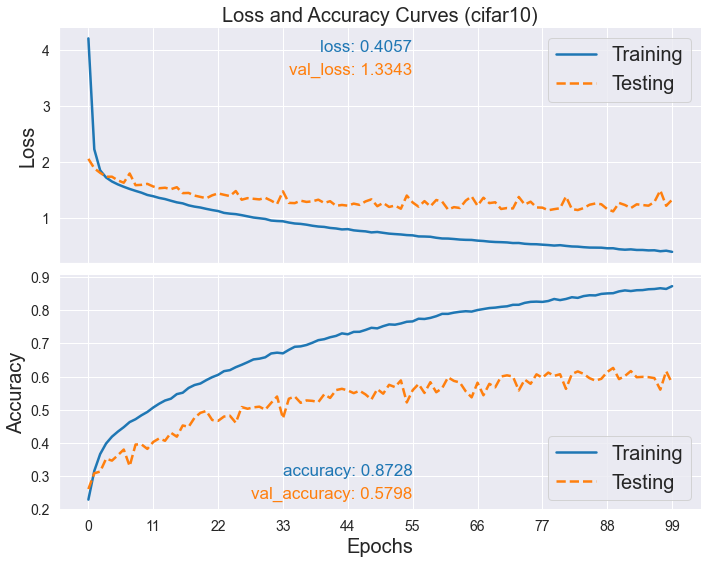

In [75]:
visualise.metric_plot(show_fig=True, history=history, dataset_name=dataset_name,
                      savefig=False, epochs=EPOCHS)

# Evaluation

In [88]:
((X_train_real, y_train_real), (X_test_real, y_test_real)), dataset_name = data.load_dataset(dataset, return_name=True)
print(X_train_real.shape, y_train_real.shape, X_test_real.shape, y_test_real.shape)

X_train_real, y_train_real = utils.preprocess_data(X_train_real, y_train_real)
X_test_real, y_test_real = utils.preprocess_data(X_test_real, y_test_real)

X_train_real.shape, y_train_real.shape, X_test_real.shape, y_test_real.shape

X_train, y_train = shuffle(X_train_real, y_train_real)
X_test, y_test = shuffle(X_test_real, y_test_real)

train_type = 2
model_path = Path.cwd() / f'reports/models/{dataset_name}/{MLConfig.TYPE_NAMES[train_type]}/E_{EPOCHS:03d}/{model.name}.h5'
m_time = datetime.fromtimestamp(model_path.stat().st_mtime).strftime('%h-%d | %I:%M:%S')
model = load_model(model_path)
print(model_path, m_time)

_, acc = model.evaluate(X_train, y_train)
_, acc = model.evaluate(X_test, y_test)

y_pred = np.argmax(model.predict(X_train), axis=-1)
report = classification_report(np.argmax(y_train, axis=1), y_pred)
print(report)

y_pred = np.argmax(model.predict(X_test), axis=-1)
report = classification_report(np.argmax(y_test, axis=1), y_pred)
print(report)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
/Users/hamzz/Development/~professional/researchGAN/reports/models/cifar10/gans/E_100/deep_model_stable.h5 Jul-18 | 05:23:13
1563/1563 [==============================] - 9s 6ms/step
              precision    recall  f1-score   support

           0       0.78      0.60      0.68      5000
           1       0.85      0.86      0.85      5000
           2       0.62      0.57      0.59      5000
           3       0.63      0.53      0.58      5000
           4       0.65      0.67      0.66      5000
           5       0.73      0.57      0.64      5000
           6       0.76      0.82      0.79      5000
           7       0.75      0.78      0.77      5000
           8       0.69      0.91      0.78      5000
           9       0.74      0.90      0.81      5000

    accuracy                           0.72     50000
   macro avg       0.72      0.72      0.72     50000
weighted avg       0.72      0.72      0.72     50000

